In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns  # For visualizing the confusion matrix

# LOAD DATA

In [ ]:
! git clone https://github.com/LiamHogarth123/Ai_Fungi_Finder.git

Cloning into 'Ai_Fungi_Finder'...
remote: Enumerating objects: 10065, done.
remote: Total 10065 (delta 0), reused 0 (delta 0), pack-reused 10065
Receiving objects: 100% (10065/10065), 2.46 GiB | 36.54 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (10061/10061), done.


# Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Test Gpu

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPUs available")

Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Remove Corrupted Images

In [2]:
import os
from PIL import Image

def identify_corrupted_images(directory):
    corrupted_images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    img.load()
            except OSError as e:
                print(f"Corrupted image: {img_path}")
                corrupted_images.append(img_path)
    return corrupted_images

# Replace '/path/to/dataset' with the path to your dataset directory
corrupted_images = identify_corrupted_images('/home/liam/git/Ai_Fungi_Finder/Data_V3/Training')

# Remove or replace corrupted images
for img_path in corrupted_images:
    # Remove the corrupted image
    os.remove(img_path)
    # Or replace with a placeholder image
    # placeholder_img.save(img_path)


# Load Plotting Function

In [9]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    num_epochs = len(model_history.history[acc])
    tick_positions = np.arange(1, num_epochs + 1, max(1, num_epochs // 10))

    axs[0].plot(range(1, num_epochs + 1), model_history.history[acc])
    axs[0].plot(range(1, num_epochs + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(tick_positions)
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1, num_epochs + 1), model_history.history['loss'])
    axs[1].plot(range(1, num_epochs + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(tick_positions)
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()

# Loading an equal amount of each mushroom species data set

In [37]:
import os
import shutil
from glob import glob

def copy_and_limit_images(source_dir, target_dir, max_images=80):
    # Ensure the target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for category in categories:
        # Make sure each category directory exists in the target directory
        category_target_dir = os.path.join(target_dir, category)
        if not os.path.exists(category_target_dir):
            os.makedirs(category_target_dir)

        # Get all images in the source directory for this category
        category_source_dir = os.path.join(source_dir, category)
        images = glob(os.path.join(category_source_dir, '*'))

        # Copy the first 'max_images' images to the target directory
        for image_path in images[:max_images]:
            shutil.copy(image_path, category_target_dir)

def copy_and_limit_images2(source_dir, target_dir, max_images=240):
    # Ensure the target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for category in categories:
        # Make sure each category directory exists in the target directory
        category_target_dir = os.path.join(target_dir, category)
        if not os.path.exists(category_target_dir):
            os.makedirs(category_target_dir)

        # Get all images in the source directory for this category
        category_source_dir = os.path.join(source_dir, category)
        images = glob(os.path.join(category_source_dir, '*'))

        # Copy the first 'max_images' images to the target directory
        for image_path in images[:max_images]:
            shutil.copy(image_path, category_target_dir)


# Define your source and target directories
source_train_dir = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Training'
target_train_dir = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited'
source_test_dir = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Testing'
target_test_dir = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Testing_Limited'

# Execute the function for both training and testing datasets
copy_and_limit_images2(source_train_dir, target_train_dir)
# copy_and_limit_images(source_test_dir, target_test_dir)


# VGG16 Model - 10 % accuray slow load times

In [3]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, Reshape



# Create an ImageDataGenerator object for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,     # Normalize pixel values to [0,1]
    rotation_range=40,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly translate images horizontally
    height_shift_range=0.2, # Randomly translate images vertically
    shear_range=0.2,    # Randomly applying shearing transformations
    zoom_range=0.2,     # Randomly zooming inside pictures
    horizontal_flip=True,  # Randomly flipping half of the images horizontally
    fill_mode='nearest' # Strategy used for filling in newly created pixels
)

# Create an ImageDataGenerator object for validation data (No data augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        target_train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
        class_mode='categorical')  # Since we use categorical_crossentropy loss, we need categorical labels

# Flow validation images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        target_test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')






# initialise model
# ///////////////////////////////////////////////////////////////////////////////////////////////////////

# Set the dimensions of the input image
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights="imagenet")

# Freeze the layers except the last 4 layers
for layer in pre_trained_model.layers[:-6]:
    layer.trainable = False


# Make the last 4 layers trainable
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

# Get the output of the last convolutional block
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# Add new classifier layers
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(9, activation='softmax')(x)  # Change to 10 for the number of mushroom species

# Create the new model
vggmodel = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)

# Compile the model
vggmodel.compile(loss='categorical_crossentropy',  # Change loss function
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# Print the model summary
vggmodel.summary()

print(train_generator.class_indices)
print(validation_generator.class_indices)

# Assuming 'dataset_train' and 'dataset_test' are properly set up data generators for your training and validation datasets
vgghist2 = vggmodel.fit(
    train_generator,  # use train_generator here
    epochs=5,
    validation_data=validation_generator  # use validation_generator here
)

vggmodel.save('/home/liam/git/Ai_Fungi_Finder/models/Vgg16')

plot_model_history(vgghist2)


NameError: name 'ImageDataGenerator' is not defined

# save model

In [15]:
model.save('/home/liam/git/Ai_Fungi_Finder/models/InceptionV3-3')


INFO:tensorflow:Assets written to: /home/liam/git/Ai_Fungi_Finder/models/InceptionV3/assets


INFO:tensorflow:Assets written to: /home/liam/git/Ai_Fungi_Finder/models/InceptionV3/assets


# Load model for more training


In [6]:
from tensorflow.keras.models import load_model

# Load the previously saved model
from tensorflow.keras.models import load_model
model = load_model('/home/liam/git/Ai_Fungi_Finder/models/InceptionV3-V3')




# Further train Model

In [ ]:
# Continue training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,  # Adjust the number of epochs as needed
    callbacks=[early_stopping, model_checkpoint]
)

# Confusion matrix

45/45 [==============================] - 5s 120ms/step


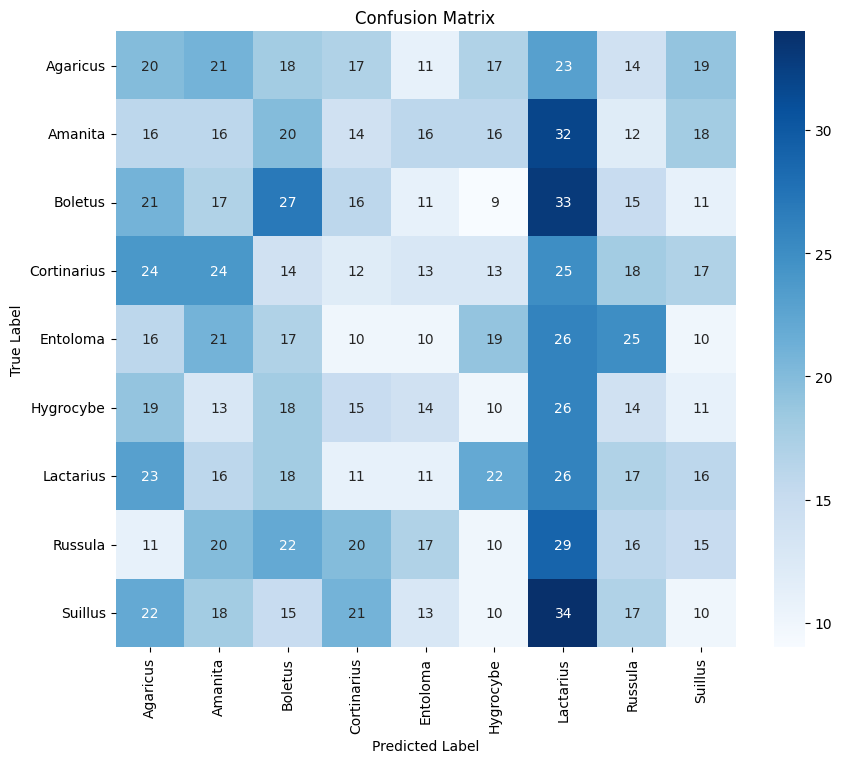

              precision    recall  f1-score   support

    Agaricus       0.12      0.12      0.12       160
     Amanita       0.10      0.10      0.10       160
     Boletus       0.16      0.17      0.16       160
 Cortinarius       0.09      0.07      0.08       160
    Entoloma       0.09      0.06      0.07       154
   Hygrocybe       0.08      0.07      0.08       140
   Lactarius       0.10      0.16      0.13       160
     Russula       0.11      0.10      0.10       160
     Suillus       0.08      0.06      0.07       160

    accuracy                           0.10      1414
   macro avg       0.10      0.10      0.10      1414
weighted avg       0.10      0.10      0.10      1414



In [10]:
# Reset the validation generator
from sklearn.metrics import confusion_matrix, classification_report

validation_generator.reset()

# Make predictions
predictions = model.predict(validation_generator, steps=len(validation_generator))

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true class indices
true_classes = validation_generator.classes

# Retrieve class labels
class_labels = list(validation_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Classification Section

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image as k_image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def predict_mushroom_species(img_path, model, class_labels):
    # Load the image file, resizing it to 224x224 pixels (as required by the model)
    img = k_image.load_img(img_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img_array = k_image.img_to_array(img)
    # Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image by scaling pixel values to match the original model's training input
    img_array = preprocess_input(img_array)
    # Make predictions
    predictions = model.predict(img_array)
    # Retrieve the most likely result, e.g., highest probability
    predicted_class_idx = np.argmax(predictions[0])
    # Map the index to the class label
    predicted_class_label = class_labels[predicted_class_idx]
    return predicted_class_label

# Example usage
img_path = '/content/Ai_Fungi_Finder/Data_V3/Training/Agaricus/299_lLa-uv876WM.jpg'  # Path to new mushroom image
predicted_class = predict_mushroom_species(img_path, model, list(train_generator.class_indices.keys()))
print(f'Predicted Mushroom Species: {predicted_class}')


1/1 [==============================] - 0s 32ms/step
Predicted Mushroom Species: Russula


In [ ]:
from tensorflow.keras.models import Model

# Assume 'pre_trained_model' is your VGG16 model loaded without the top and with ImageNet weights
feature_extractor = Model(inputs=pre_trained_model.input, outputs=pre_trained_model.get_layer('block5_pool').output)
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_to_model(model, generator, num_components=50):
    """
    Applies PCA to the output of a given model based on the data provided by a generator.

    Args:
    - model: TensorFlow/Keras model to extract features.
    - generator: Data generator that feeds data into the model.
    - num_components: Number of principal components to retain.

    Returns:
    - pca_features: PCA-reduced feature set.
    """
    # Extract features from the model using the generator
    features = model.predict(generator, steps=len(generator))

    # Reshape the features to be two-dimensional
    num_samples = features.shape[0]
    features_flattened = features.reshape(num_samples, -1)

    # Initialize and fit PCA
    pca = PCA(n_components=num_components)
    pca_features = pca.fit_transform(features_flattened)

    return pca_features


In [40]:
import os
import cv2
import numpy as np

def remove_background(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Unable to open image file {image_path}")
        return None
    
    # Create an initial mask
    mask = np.zeros(image.shape[:2], np.uint8)

    # Create temporary arrays for the GrabCut algorithm
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Define a rectangle around the object for the GrabCut algorithm
    rect = (10, 10, image.shape[1] - 20, image.shape[0] - 20)

    # Apply GrabCut algorithm
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Modify the mask to set the background pixels to 0 and the foreground pixels to 1
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Apply the mask to the image
    foreground = image * mask2[:, :, np.newaxis]

    # Create a black background image
    black_background = np.zeros_like(image)

    # Combine the foreground with the black background
    result = cv2.add(foreground, black_background)

    return result

def process_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, filename)
            result = remove_background(image_path)
            if result is not None:
                output_path = os.path.join(output_folder, filename.rsplit('.', 1)[0] + '_no_background.' + filename.rsplit('.', 1)[1])
                cv2.imwrite(output_path, result)
                print(f"Processed and saved: {output_path}")
            else:
                print(f"Failed to process: {image_path}")



base_input_folder = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited'
base_output_folder = '/home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited_no_background'

folders = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus' ]

# 

for folder in folders:
    input_folder = os.path.join(base_input_folder, folder)
    output_folder = os.path.join(base_output_folder, folder + '_no_background')
    process_images(input_folder, output_folder)




Processed and saved: /home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited_no_background/Agaricus_no_background/121_yYP_idjfBCU_no_background.jpg
Processed and saved: /home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited_no_background/Agaricus_no_background/226_0du5e8k_cCA_no_background.jpg
Processed and saved: /home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited_no_background/Agaricus_no_background/063_Fa4IMCTXq04_no_background.jpg
Processed and saved: /home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited_no_background/Agaricus_no_background/322_Vo7-YIIajYY_no_background.jpg
Processed and saved: /home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited_no_background/Agaricus_no_background/032_2r2eDI3Hvlc_no_background.jpg
Processed and saved: /home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited_no_background/Agaricus_no_background/065_ca8G5lwf7CU_no_background.jpg
Processed and saved: /home/liam/git/Ai_Fungi_Finder/Data_V3/Training_Limited_no_background/Agaricus_no_backgroun